In [7]:
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model = model.to(DEVICE)

In [8]:
class ActivationTracker:
    def __init__(self, layers):
        self.activations = {}
        self.layers = layers
        self.hooks = []
        for l in layers:
            self.hooks.append(
                self.register_hook(l)
            )

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        self.activations = []

    def register_hook(self, layer):
        def hook(module, inputs, outputs):
            self.activations[layer] = outputs.detach().cpu()
            return outputs
        return layer.register_forward_hook(hook)
    
    def shapes(self):
        shapes = []
        for l in self.layers:
            a = self.activations[l]
            shapes.append(list(a.shape))
        return shapes
    
    def flat_activations(self):
        data = []
        for l in self.layers:
            data.append(self.activations[l].flatten())
        return torch.concat(data)


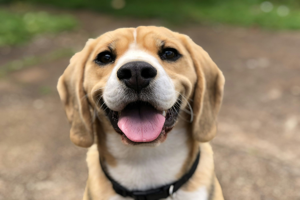

In [18]:
image1 = Image.open("./data/dog.jpeg")
image2 = Image.open("./data/golden.jpg")
image1.resize((300, 200))

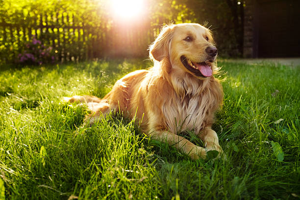

In [16]:
image2.resize((300, 200))

In [30]:
tracker = ActivationTracker([layer for stage in model.resnet.encoder.stages for layer in stage.layers])
inputs = processor([image1, image2], return_tensors="pt")
model.eval()
with torch.no_grad():
    inputs = inputs.to(DEVICE)
    logits = model(**inputs).logits

    # model predicts one of the 1000 ImageNet classes
    predicted_label = logits.argmax(-1).cpu().tolist()
    
    for p in predicted_label:
        print(model.config.id2label[p])

beagle
golden retriever
